In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2
from tensorflow.keras import models,layers,Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
class_names = ['AD','CN','MCI']

In [3]:
path=r"G:\dataset\MRI\Training"

In [4]:
strategy = tf.distribute.get_strategy()
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * 16
EPOCHS = 50
output_size=len(class_names)
input_shape=(256, 256)

In [5]:
trainData=[]
trainDataLables=[]
for name in class_names:
    images = [cv2.imread(file,cv2.COLOR_BGR2GRAY) for file in glob.glob(path+"\\"+name+r'\*.png')]
    for i in images:
        i=cv2.resize(i,(256, 256))
        trainData.append(np.asarray(i))
        trainDataLables.append(name)


trainData=np.asarray(trainData)
trainDataLables=np.asarray(trainDataLables)

In [6]:
trainData,trainDataLables=shuffle(trainData,trainDataLables)

In [7]:
lableId=[]
for i in range(len(trainDataLables)):
    for j in range(len(class_names)):
        if trainDataLables[i]==class_names[j]:
            lableId.append(j)

trainLables=tf.keras.utils.to_categorical(lableId, num_classes=len(class_names), dtype='float32')

In [8]:
x_train,x_val,y_train,y_val=train_test_split(trainData, trainLables, test_size=0.2, random_state=42)

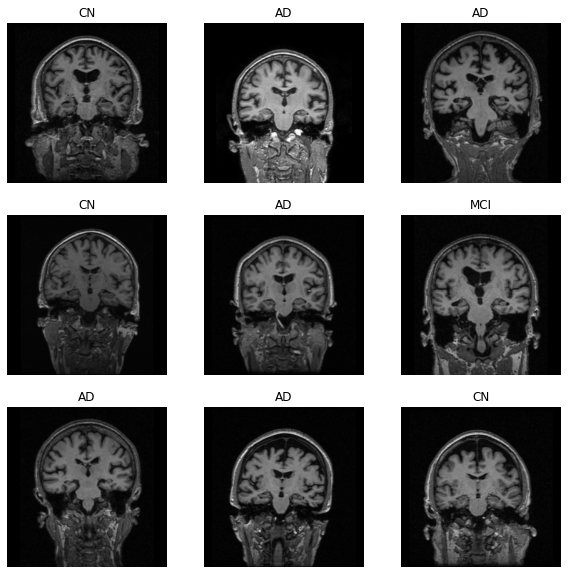

In [9]:
plt.figure(figsize=(10, 10))
i=0
for x in range(9):
    ax = plt.subplot(3, 3, i+1)
    i+=1
    plt.imshow(trainData[x])
    plt.title(trainDataLables[x])
    plt.axis("off")

In [10]:
def conv_block(filters):
    block = Sequential([
        layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D()
    ]
    )
    
    return block

In [11]:
def dense_block(units, dropout_rate):
    block = Sequential([
        layers.Dense(units, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate)
    ])
    
    return block

In [12]:
model = models.Sequential([
    layers.Conv2D(filters=16,kernel_size=7,kernel_initializer='he_uniform',activation='relu',input_shape=input_shape),
    layers.Conv2D(filters=16,kernel_size=7,kernel_initializer='he_uniform',activation='relu'),
    layers.MaxPooling2D(),


    conv_block(32),
    conv_block(64),
        
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    dense_block(512, 0.5),
    dense_block(128, 0.3),
    dense_block(64, 0.1),
    layers.Dense(output_size, activation='softmax')
])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      2368      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 244, 244, 16)      12560     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 122, 16)      0         
_________________________________________________________________
sequential (Sequential)      (None, 61, 61, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 30, 30, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 15, 15, 128)       27072     
_______________________________________

In [13]:
METRICS = [tf.keras.metrics.AUC(name='auc')]
model.compile(
        optimizer='adam',
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=METRICS
    )

In [14]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [15]:
history = model.fit(
    x_train,y_train,
    validation_data=(x_val,y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS,verbose=2
)

Train on 480 samples, validate on 120 samples
Epoch 1/50
480/480 - 63s - loss: 1.5824 - auc: 0.4874 - val_loss: 7.8091 - val_auc: 0.5032
Epoch 2/50
480/480 - 58s - loss: 1.1983 - auc: 0.5364 - val_loss: 16.5440 - val_auc: 0.5041
Epoch 3/50
480/480 - 57s - loss: 1.1616 - auc: 0.5576 - val_loss: 1.3804 - val_auc: 0.5398
Epoch 4/50
480/480 - 58s - loss: 1.1376 - auc: 0.5310 - val_loss: 5.9412 - val_auc: 0.4875
Epoch 5/50
480/480 - 58s - loss: 1.1199 - auc: 0.5756 - val_loss: 1.3268 - val_auc: 0.5513
Epoch 6/50
480/480 - 57s - loss: 1.1005 - auc: 0.5743 - val_loss: 1.1673 - val_auc: 0.5642
Epoch 7/50
480/480 - 57s - loss: 1.0806 - auc: 0.5927 - val_loss: 1.1791 - val_auc: 0.5461
Epoch 8/50
480/480 - 57s - loss: 1.0838 - auc: 0.5971 - val_loss: 1.0965 - val_auc: 0.5631
Epoch 9/50
480/480 - 58s - loss: 1.0895 - auc: 0.5808 - val_loss: 1.0843 - val_auc: 0.5798
Epoch 10/50
480/480 - 58s - loss: 1.0524 - auc: 0.6309 - val_loss: 1.1110 - val_auc: 0.5412
Epoch 11/50
480/480 - 57s - loss: 1.0418 -

In [16]:
model.save(path+"\\alzheimer_model_trained.h5")

In [17]:
model.evaluate(x_val,y_val)

120/120 [==============================] - 3s 26ms/sample - loss: 1.0843 - auc: 0.5798


[1.0843051354090372, 0.5797916]